In [1]:
!pip install --upgrade albumentations

Processing c:\users\omrig\appdata\local\pip\cache\wheels\f0\a0\61\e50f93165a5ec7e7f5d65064e513239505bc4c06d2289557d3\albumentations-0.4.5-cp37-none-any.whl
Processing c:\users\omrig\appdata\local\pip\cache\wheels\97\ec\48\0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0\imgaug-0.2.6-cp37-none-any.whl
  Using cached opencv_python-4.2.0.34-cp37-cp37m-win_amd64.whl (33.0 MB)


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
from pylab import rcParams
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import rc
import albumentations as A
import random

#RANDOM_SEED = 42
#random.seed(RANDOM_SEED)
#np.random.seed(RANDOM_SEED)

In [22]:
MAIN_PATH = r'C:\Users\omrig\Documents\Kaggle Projects\Wheat Detection\global-wheat-detection'
TRAIN_PATH = MAIN_PATH + r'\train'
CSV_FILE =  MAIN_PATH + r'\train.csv'

In [23]:
data = pd.read_csv(CSV_FILE)
data.head()

image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1

In [29]:
def modify_df(coco_df):
  bboxes = np.stack(coco_df['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
  df = pd.DataFrame(bboxes, columns = ['Xmin', 'Ymin','width', 'height'])
  id_col = data['image_id'].reset_index().drop('index', axis=1)
  id_col = id_col + '.jpg'
  df = df.join(id_col)
  df['Xmax'] = df.apply(lambda col: col['Xmin'] + col['width'], axis=1)
  df['Ymax'] = df.apply(lambda col: col['Ymin'] + col['height'], axis = 1)
  del df["width"]
  del df["height"]
  df = df[['image_id','Xmin', 'Ymin','Xmax','Ymax']]
  return df

In [30]:
data = modify_df(data)
data.head()

image_id   Xmin   Ymin   Xmax   Ymax
0  b6ab77fd7.jpg  834.0  222.0  890.0  258.0
1  b6ab77fd7.jpg  226.0  548.0  356.0  606.0
2  b6ab77fd7.jpg  377.0  504.0  451.0  664.0
3  b6ab77fd7.jpg  834.0   95.0  943.0  202.0
4  b6ab77fd7.jpg   26.0  144.0  150.0  261.0

In [31]:
BOX_COLOR = (0, 255, 0)

def add_bboxes(img, bboxes, color = BOX_COLOR, thickness = 5):
  if len(bboxes)>0:
    for box in bboxes:
      stpt = int(box[0]), int(box[1])
      endpt = int(box[2]), int(box[3])         
      img = cv2.rectangle(img,stpt,endpt,color,thickness)
  return img

In [32]:
def show_image(image, bboxes):
  image = add_bboxes(image.copy(), bboxes)
  fig = plt.figure(figsize=(9, 6))
  plt.imshow(
    cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
    interpolation='nearest'
  )
  plt.axis('off')
  fig.tight_layout()
  plt.show()

In [33]:
def extract_boxes(df, image_id):
  records = data[data['image_id']==image_id]
  return np.array(records[['Xmin','Ymin','Xmax','Ymax']])

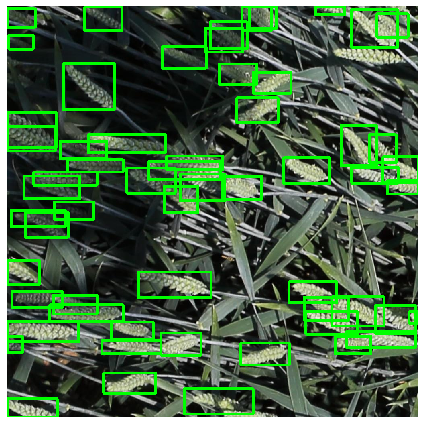

In [39]:
#form = cv2.imread("form.png")
sample_image_id = '0a7338e6f.jpg'
sample_image = cv2.imread(TRAIN_PATH + f'/{sample_image_id}')
sample_bboxes = extract_boxes(data, sample_image_id)
sample_field_id = np.ones(len(sample_bboxes))
show_image(sample_image, sample_bboxes)

# Exploration

In [43]:
bbox_params = A.BboxParams(
  format='pascal_voc', 
  min_area=1, 
  min_visibility=0.5, 
  label_fields=['field_id']
)

In [44]:
aug = A.Compose([
    A.Flip(always_apply=True)
], bbox_params=bbox_params)

In [45]:
sample = {'image':sample_image, 'bboxes':sample_bboxes, 'field_id':sample_field_id}
augmented = aug(**sample)
augmented['bboxes']

[(104.0, 297.0, 192.0, 397.0),
 (51.39999999999998, 8.0, 166.0, 103.4),
 (757.0, 143.0, 884.0, 258.0),
 (426.0, 39.0, 518.0, 106.0),
 (738.0, 2.0, 831.0, 61.0),
 (221.0, 377.0, 335.0, 442.0),
 (899.0, 978.0, 1024.0, 1024.0),
 (528.0, 101.0, 638.0, 155.0),
 (317.0, 165.0, 411.0, 217.0),
 (872.0, 513.0, 979.0, 576.0),
 (349.0, 228.0, 452.0, 290.0),
 (944.0, 633.0, 1023.0, 693.0),
 (151.0, 761.0, 280.0, 817.0),
 (6.0, 746.0, 106.0, 816.0),
 (0.0, 375.0, 88.0, 439.0),
 (321.0, 839.0, 442.0, 894.0),
 (660.0, 787.0, 764.0, 830.0),
 (549.0, 449.0, 633.0, 514.0),
 (843.0, 423.0, 982.0, 480.0),
 (402.0, 144.0, 496.0, 195.0),
 (954.0, 6.0, 1023.0, 53.0),
 (902.0, 264.0, 1024.0, 352.0),
 (846.0, 786.0, 1024.0, 836.0),
 (55.0, 320.0, 121.0, 390.0),
 (654.0, 914.0, 784.0, 964.0),
 (516.0, 662.0, 697.0, 726.0),
 (0.0, 435.0, 77.0, 468.0),
 (735.0, 382.0, 873.0, 413.0),
 (365.0, 2.0, 439.0, 60.0),
 (776.0, 337.0, 892.0, 380.0),
 (25.0, 19.0, 103.0, 77.0),
 (203.0, 686.0, 322.0, 739.0),
 (437.0, 55.0,

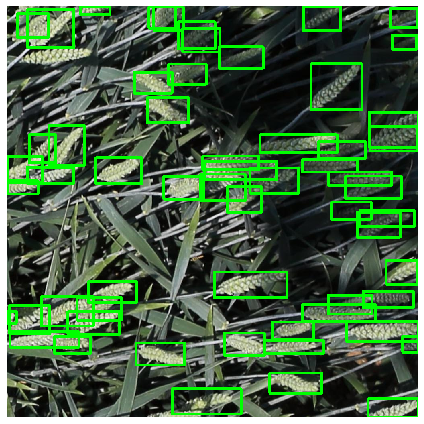

In [46]:
show_image(augmented['image'], augmented['bboxes'])

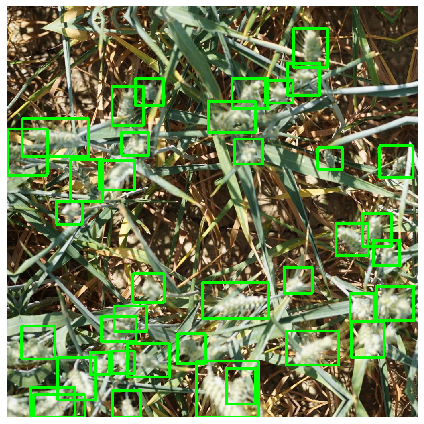

In [84]:
aug = A.Compose([
  A.Rotate(limit=80, always_apply=True)
], bbox_params=bbox_params)

augmented = aug(**sample)
show_image(augmented['image'], augmented['bboxes'])

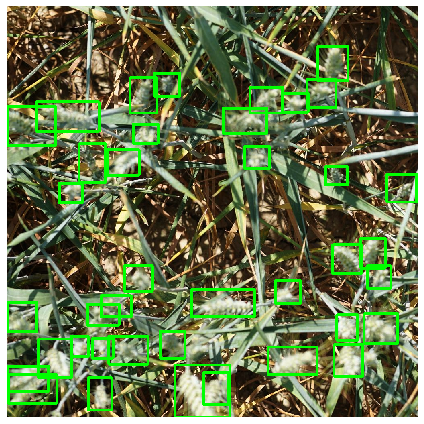

In [83]:
aug = A.Compose([
    A.RandomGamma(gamma_limit=(50, 200), always_apply=True)
], bbox_params=bbox_params)

augmented = aug(**sample)
show_image(augmented['image'], augmented['bboxes'])

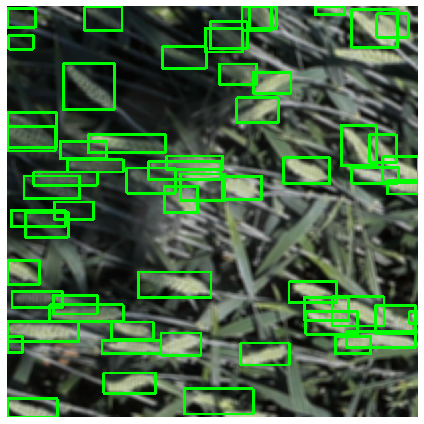

In [49]:
aug = A.Compose([
    A.RandomFog( fog_coef_lower=0.2, fog_coef_upper=0.5, alpha_coef=0.08, always_apply=True)
], bbox_params=bbox_params)

augmented = aug(**sample)
show_image(augmented['image'], augmented['bboxes'])

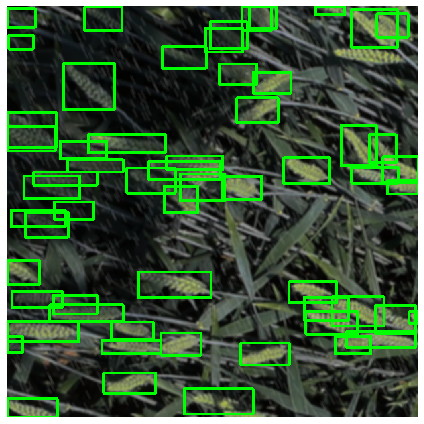

In [50]:
aug = A.Compose([
    A.RandomRain(slant_lower=-5, slant_upper=5, always_apply=True)
], bbox_params=bbox_params)

augmented = aug(**sample)
show_image(augmented['image'], augmented['bboxes'])

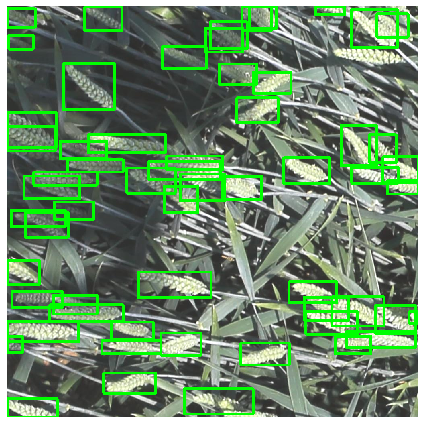

In [51]:
aug = A.Compose([
    A.RandomBrightnessContrast(always_apply=True),
], bbox_params=bbox_params)

augmented = aug(**sample)
show_image(augmented['image'], augmented['bboxes'])

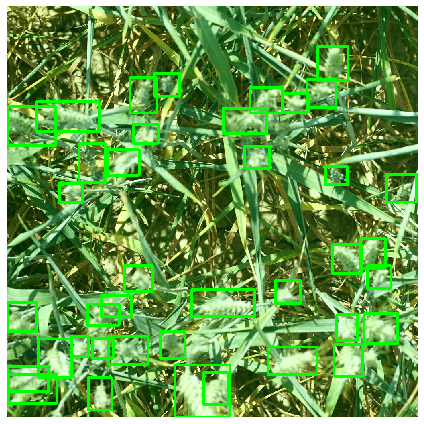

In [85]:
aug = A.Compose([
    A.RGBShift(
      always_apply=True, 
      r_shift_limit=30, 
      g_shift_limit=30,
      b_shift_limit=30
    ),
], bbox_params=bbox_params)

augmented = aug(**sample)
show_image(augmented['image'], augmented['bboxes'])

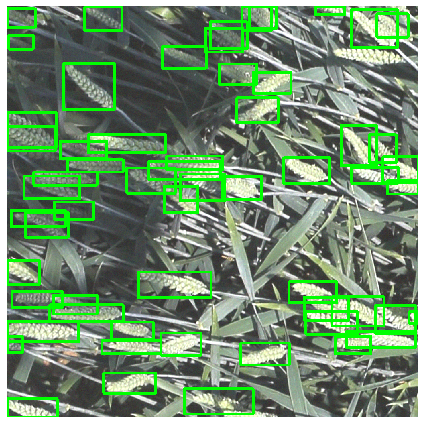

In [53]:
aug = A.Compose([
    A.GaussNoise(
      always_apply=True,
      var_limit=(0, 200),
      mean=50
    ),
], bbox_params=bbox_params)


augmented = aug(**sample)
show_image(augmented['image'], augmented['bboxes'])

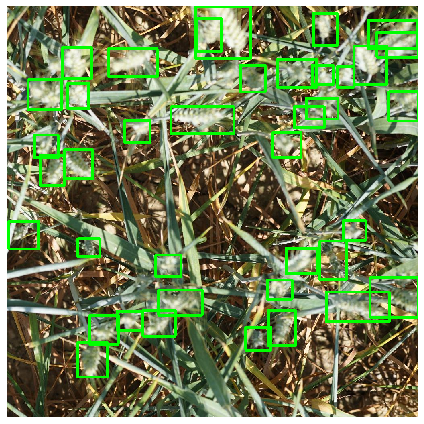

In [109]:
aug = A.Compose([
    A.Flip(
      always_apply=True
    ),
], bbox_params=bbox_params)


augmented = aug(**sample)
show_image(augmented['image'], augmented['bboxes'])

# Augmenting Scanned Documents

In [98]:
seq_aug = A.Compose([
    A.Flip(p=0.8),
    A.RandomGamma(gamma_limit=(50, 200), p=0.3),
    A.RandomFog( fog_coef_lower=0.2, fog_coef_upper=0.5, alpha_coef=0.08, p=0.2),
    A.RandomRain(slant_lower=-5, slant_upper=5, p=0.1),
    A.RGBShift(r_shift_limit=20, g_shift_limit=20,b_shift_limit=20, p=0.3),
    A.RandomBrightnessContrast(p=0.3),
    #A.Rotate(limit=80, p=0.9),
    #A.RandomRotate90(p=0.3),
    A.GaussNoise( var_limit=(0, 200),mean=50, p=0.25)
], bbox_params=bbox_params)

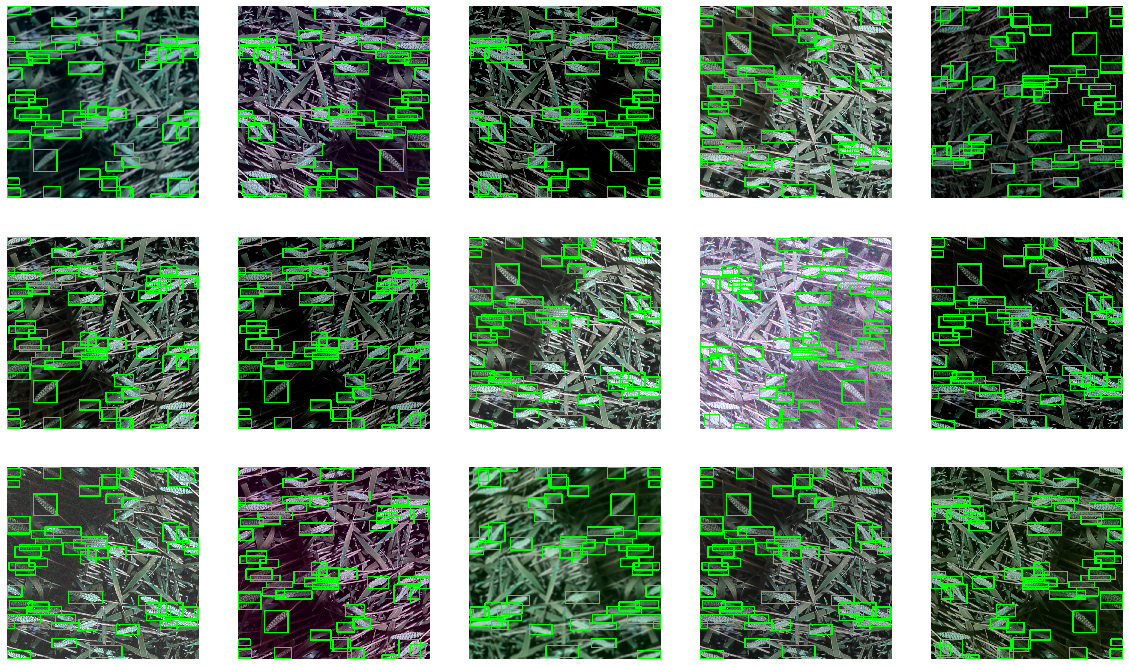

<Figure size 432x288 with 0 Axes>

In [99]:
sample_image_id = '0a7338e6f.jpg'
sample_image = cv2.imread(TRAIN_PATH + f'/{sample_image_id}')
sample_bboxes = extract_boxes(data, sample_image_id)
sample_field_id = np.ones(len(sample_bboxes))

sample = {'image':sample_image, 'bboxes':sample_bboxes, 'field_id':sample_field_id}

fig = plt.figure(figsize=(20,12))
n_rows = 3
n_col = 5
for i in range(n_rows*n_col):
  augmented = seq_aug(**sample)
  image = add_bboxes(augmented['image'].copy(), augmented['bboxes'])
  ax = fig.add_subplot(n_rows,n_col,i+1)
  ax.imshow(
    cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
    interpolation='nearest'
  )
  ax.axis('off')
  ax.imshow(image)
plt.show()
plt.tight_layout()



# Creating Augmented Dataset

In [100]:
files_ls = [file_name for file_name in os.listdir(TRAIN_PATH) if '.jpg' in file_name]
files_ls[:5], len(files_ls)

(['00333207f.jpg',
  '005b0d8bb.jpg',
  '006a994f7.jpg',
  '00764ad5d.jpg',
  '00b5c6764.jpg'],
 3422)

In [103]:
DATASET_PATH = 'data/augmented'
IMAGES_PATH = MAIN_PATH + r'\aug_images_2'

Using the format:

`path/to/image.jpg,x1,y1,x2,y2,class_name`

In [104]:
rows = []
#ind_list = range(len(files_ls))
for i, image_id in enumerate(files_ls):
    #image_id = files_ls[i]
    image = cv2.imread(TRAIN_PATH + f'/{image_id}')
    bboxes = extract_boxes(data, image_id)
    field_id = np.ones(len(bboxes))
    sample = {'image':image, 'bboxes':bboxes, 'field_id':field_id}
    augmented = seq_aug(**sample)
    file_name = f'aug_{i}_{image_id}'
    for bbox in augmented['bboxes']:
        x_min, y_min, x_max, y_max = map(lambda v: int(v), bbox)
        rows.append({
            'image_id': f'{file_name}',
            'Xmin': x_min,
            'Ymin': y_min,
            'Xmax': x_max,
            'Ymax': y_max,
    })
    cv2.imwrite(f'{IMAGES_PATH}/{file_name}', augmented['image'])

pd.DataFrame(rows).to_csv(f'{IMAGES_PATH}/augmented.csv', header=True, index=None)

In [105]:
pd.DataFrame(rows)

image_id  Xmin  Ymin  Xmax  Ymax
0          aug_0_00333207f.jpg     0   654    37   765
1          aug_0_00333207f.jpg     0   817   135   915
2          aug_0_00333207f.jpg     0   192    22   273
3          aug_0_00333207f.jpg     4   342    67   380
4          aug_0_00333207f.jpg    82   334   164   415
...                        ...   ...   ...   ...   ...
147788  aug_3421_ffdf83e42.jpg     4   536    78   605
147789  aug_3421_ffdf83e42.jpg    68   321   127   377
147790  aug_3421_ffdf83e42.jpg   472    31   534   112
147791  aug_3421_ffdf83e42.jpg   779   585   845   681
147792  aug_3421_ffdf83e42.jpg   745   229   824   281

[147793 rows x 5 columns]